In [1]:
%load_ext autoreload
%autoreload 2

import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('../src/')
from simple_transformer import MultilayerTransformer, initialize_weights, train_model
from markov_utilities import (
    calculate_sequence_probabilities,
    compute_myopic_entropy_from_MSP,
    epsilon_machine_to_graph,
    get_recurrent_subgraph,
    to_mixed_state_presentation,
    get_recurrent_subgraph,
    calculate_empirical_sequence_probabilities,
    create_transition_matrix,
    
)

from entropy_analysis import (
    compute_conditional_entropy,
    compute_empirical_conditional_entropy,
    inverse_binary_entropy,

)

from error_analysis import (
    compute_minimum_error,
)

from visualization import visualize_graph
from processes import RRXORProcess, GoldenMeanProcess, ZeroOneRProcess, EvenProcess, Mess3Process


ModuleNotFoundError: No module named 'simple_transformer'

# The Mess3 Process

## Visualizing the Epsilon Machine
Let's start with visualizing the Epsilon Machine

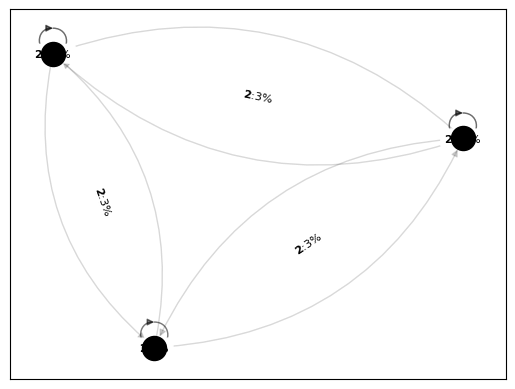

In [ ]:
Mess3 = Mess3Process()

# visualize the epsilon machine
graph = epsilon_machine_to_graph(Mess3.T)
visualize_graph(graph, draw_mixed_state=False)

## Mixed State Presentation

now let's compute the mixed state presentation and visualize it

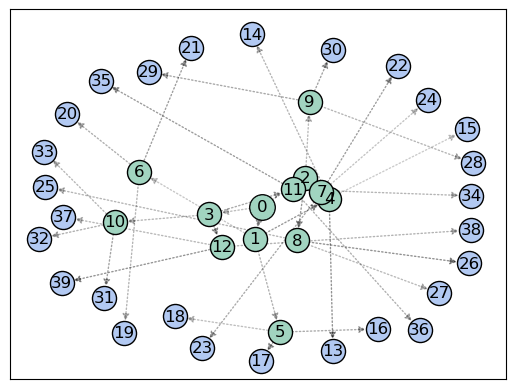

In [ ]:
MSP = to_mixed_state_presentation(Mess3.T, threshold=1e-5, max_depth=3)
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph(G_MSP, layout='spring', draw_edge_labels=False, draw_mixed_state=True, draw_color=False)

now let's extract the recurrent part of the MSP, hopefully this should leave us with a HMM that is isomorphic to the original process

In [2]:
recurrent_subgraph = get_recurrent_subgraph(G_MSP)
visualize_graph(recurrent_subgraph,  draw_edge_labels=True, draw_mixed_state=True, draw_color=False)

NameError: name 'get_recurrent_subgraph' is not defined

## Myopic Entropy

plot the myopic entropy diagram

In [3]:
# myopic entropy
plt.plot(compute_myopic_entropy_from_MSP(MSP,30))
plt.ylabel('Myopic Entropy [bits]'); plt.xlabel('Block Length'); plt.title('RRXOR Myopic Entropy')

NameError: name 'compute_myopic_entropy_from_MSP' is not defined

## Length-L word Distribution

Now we will compute word distributions at different lengths

In [7]:
import pandas as pd
seq_probs = calculate_sequence_probabilities(RRXOR.T, 20)
data = []
for length, sequences in seq_probs.items():
    for sequence, probability in sequences.items():
        data.append({'length': length, 'sequence': sequence, 'probability': probability})

df = pd.DataFrame(data)
df.query('length == 2').sort_values('probability', ascending=False).head(10)

,length,sequence,probability
2,2,00,0.25
5,2,11,0.25
3,2,01,0.25
4,2,10,0.25


In [8]:
def calculate_probabilities(df, length):
    # Get the length and length + 1 data
    df_length = df[df['length'] == length]
    df_length_plus_one = df[df['length'] == length + 1]

    # Initialize a dictionary to store the probabilities
    probabilities = {'sequence': [], 'prob(0)': [], 'prob(1)': []}

    # For each length sequence
    for sequence in df_length['sequence']:
        # Get the probabilities of emitting a 0 or a 1 from the length + 1 data
        prob_0 = df_length_plus_one['probability'][df_length_plus_one['sequence'].str.startswith(sequence + '0')].sum()
        prob_1 = df_length_plus_one['probability'][df_length_plus_one['sequence'].str.startswith(sequence + '1')].sum()
        
        # Normalize the probabilities so they sum to 1
        total_prob = prob_0 + prob_1
        if total_prob > 0:
            prob_0 /= total_prob
            prob_1 /= total_prob
        
        # Add the probabilities to the dictionary
        probabilities['sequence'].append(sequence)
        probabilities['prob(0)'].append(prob_0)
        probabilities['prob(1)'].append(prob_1)

    # Convert the dictionary to a DataFrame
    df_new = pd.DataFrame(probabilities)
    #sort the dataframe by the probability of emitting a 0
    df_new = df_new.sort_values('prob(0)', ascending=False)
    return df_new

df_new = calculate_probabilities(df, 2)
df_new

,sequence,prob(0),prob(1)
0,00,0.666667,0.333333
3,11,0.666667,0.333333
1,01,0.333333,0.666667
2,10,0.333333,0.666667


## Building Processes from length-L histories

If we build a process using length 3 histories as states, what does that look like, what does the MSP look like, and what does the recurrent portion of the MSP look like?


The length-3 world length process has this many states:  8  and looks like this: 


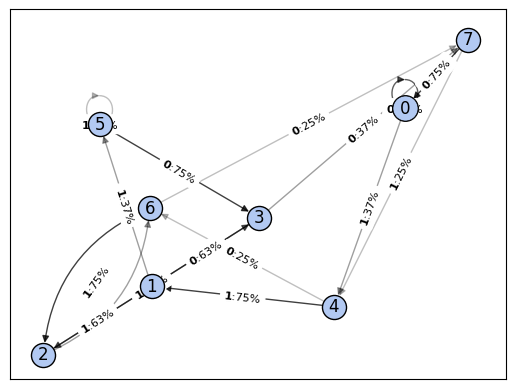

the MSP has this many states:  15  and looks like this: 


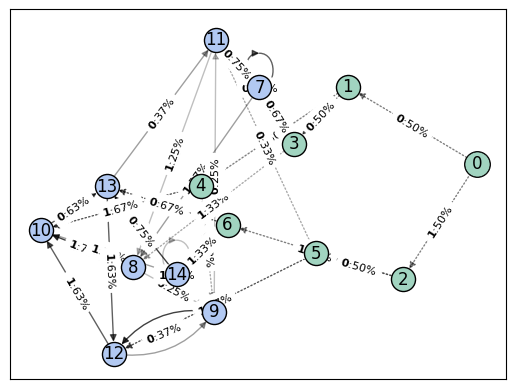

the recurrent subgraph has this many states:  8  and looks like this: 


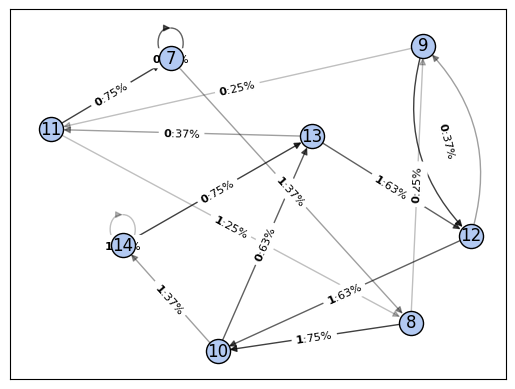

In [9]:
state_names, T, eprobs = create_transition_matrix(seq_probs, 3)
G = epsilon_machine_to_graph(T)
print("The length-3 world length process has this many states: ", len(state_names), " and looks like this: ")
visualize_graph_with_selective_offset(G, layout='spring', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)
MSP = to_mixed_state_presentation(T, threshold=1e-5)
print("the MSP has this many states: ", MSP.shape[1], " and looks like this: ") 
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph_with_selective_offset(G_MSP, layout='spring', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)
recur = get_recurrent_subgraph(G_MSP)
print("the recurrent subgraph has this many states: ", len(recur.nodes), " and looks like this: ")
visualize_graph_with_selective_offset(recur, layout='spring', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)

## MSP of the MSP? why not

the MSP of the MSP has this many states:  15  and looks like this: 


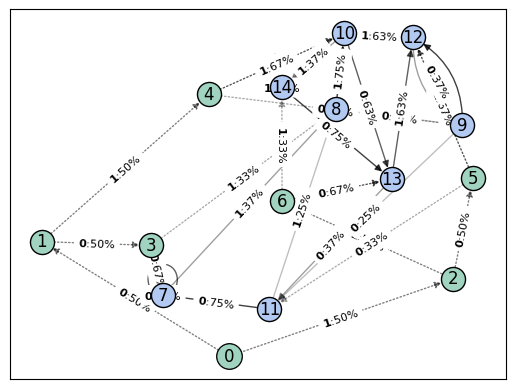

the recurrent subgraph has this many states:  8  and looks like this: 


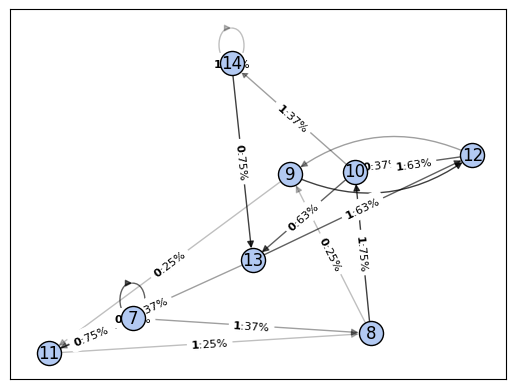

In [10]:
# make an MSP of the MSP
MSP_MSP = to_mixed_state_presentation(MSP, threshold=1e-5)
print("the MSP of the MSP has this many states: ", MSP_MSP.shape[1], " and looks like this: ")
G_MSP_MSP = epsilon_machine_to_graph(MSP_MSP)
visualize_graph_with_selective_offset(G_MSP_MSP, layout='spring', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)
# get recurrent
recurrent_subgraph = get_recurrent_subgraph(G_MSP_MSP)
print("the recurrent subgraph has this many states: ", len(recurrent_subgraph.nodes), " and looks like this: ")
visualize_graph_with_selective_offset(recurrent_subgraph, layout='spring', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)

## Creating data, feeding it into a Transformer to Train

In [181]:
# Define a config for the transformer and training
config = {
    # transformer config
    'd_vocab': 2,
    'd_model': 16,
    'input_size': 3,  # context length
    'd_head': 16,
    'n_head': 4,
    'd_mlp': 4*16,
    'n_layers': 4,
    # training config
    'batch_size': 32,
    'sequence_length': 5000,
    'num_epochs': 20,
    'learning_rate': 1.5e-2,
    'weight_decay': 0.0,
    'patience': 1000,
    'factor': 0.5
}

# Generate sequence data with positions
train_loader, test_loader, sequence_positions = RRXOR.prepare_data(config['sequence_length'], config['input_size'],
                                                                   split_ratio=0.8, batch_size=config['batch_size'],
                                                                   with_positions=True)

print(f"The number of batches in the training set is {len(train_loader)}")

# Model Definition
model = MultilayerTransformer(d_vocab=config['d_vocab'], d_model=config['d_model'], input_size=config['input_size'], 
                              d_head=config['d_head'], n_head=config['n_head'], d_mlp=config['d_mlp'], n_layers=config['n_layers'])
model.apply(initialize_weights)

# Check if CUDA is available and move the model to GPU if it is
if torch.cuda.is_available():
    model = model.cuda()
print('CUDA Available:', torch.cuda.is_available())

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=config['patience'], factor=config['factor'], verbose=True)

# Training
model = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=config['num_epochs'], verbose=True)

The number of batches in the training set is 125
CUDA Available: True
| Epoch | Training Acc. | Loss | Overall Acc. | Last Bit Acc. |
|   1   |    57.06%    |    0.6647     |      55.24%       |      54.69%      |
|   2   |    63.07%    |    0.6736     |      52.86%       |      55.18%      |
|   3   |    64.14%    |    0.7079     |      58.33%       |      63.96%      |
|   4   |    65.97%    |    0.6965     |      60.06%       |      63.96%      |
|   5   |    66.33%    |    0.6324     |      58.98%       |      63.09%      |
|   6   |    66.52%    |    0.6860     |      60.06%       |      63.96%      |
|   7   |    66.57%    |    0.7139     |      57.85%       |      63.38%      |
|   8   |    66.58%    |    0.6183     |      58.43%       |      64.26%      |
|   9   |    66.58%    |    0.6490     |      60.25%       |      63.09%      |
|  10   |    66.57%    |    0.6864     |      59.02%       |      63.96%      |
|  11   |    66.45%    |    0.6580     |      59.77%       |      